In [2]:
import network
from trainer import DGMTrainer, DGMTrainer_2D
from visualize import *
from data_sampling import *
from utility_functions import *

# Deep Galerkin Method in 1D

In [3]:
lx_1d = 2.0
T_max = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 1500
N_IC = 400
N_BC =400

## Functions to implement the internal and boundary conditions

In [4]:
def source_term_fn(t, x, alpha):
    # f(t,x) = u_t - alpha*u_xx (plug known solution into PDE)
    # u_t = -exp(-t)*sin(pi*x)
    # u_xx = -pi^2 * exp(-t) * sin(pi*x)
    return (-torch.exp(-t) + ALPHA * torch.pi**2 * torch.exp(-t)) * torch.sin(torch.pi * x)

def initial_condition_fn(x):
    # u(x, 0) = sin(pi*x)
    return torch.sin(torch.pi * x)

def boundary_condition_fn(t, x):
    # u(0, t) = u(1, t) = exp(-t)*sin(0 or pi) = 0
    return torch.zeros_like(t)

## Data Preparation

In [5]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
x_int, t_int = generate_domain_points(N_INT, bounds_1d, T_max)
f_tx = source_term_fn(t_int, x_int, ALPHA).to(device)
interior_data_1d = (t_int, x_int, f_tx)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
x_ic = generate_ic_points(N_IC, bounds_1d)
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn(x_ic).to(device)
ic_data_1d = (t_ic, x_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
x_bc = generate_boundary_points(N_BC, bounds_1d)
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn(t_bc, x_bc).to(device)
bc_data_1d = (t_bc, x_bc, u_bc)

## Visualizing the Sampled data

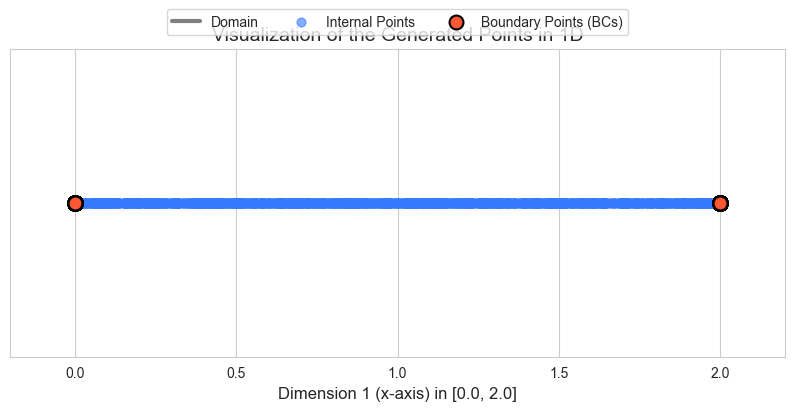

In [6]:
visualize_points_1d(x_int,x_bc, bounds_1d)

## Neural Network initialization

In [7]:
num_layers = 5
nodes_per_layer = 64
learning_rate = 0.001
epochs = 5000

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)

trainer = DGMTrainer(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [8]:
trainer.train(
    epochs=epochs,
    interior_data=interior_data_1d,
    ic_data=ic_data_1d,
    bc_data=bc_data_1d,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 1500, IC: 400, BC: 400 points.
Epoch 100/5000 | Total Loss: 0.9311 | L_pde: 0.0443 | L_ic: 0.0096 | L_bc: 0.0081
Epoch 200/5000 | Total Loss: 0.2500 | L_pde: 0.0318 | L_ic: 0.0028 | L_bc: 0.0015
Epoch 300/5000 | Total Loss: 0.1065 | L_pde: 0.0268 | L_ic: 0.0011 | L_bc: 0.0005
Epoch 400/5000 | Total Loss: 0.0673 | L_pde: 0.0189 | L_ic: 0.0007 | L_bc: 0.0003
Epoch 500/5000 | Total Loss: 0.0276 | L_pde: 0.0087 | L_ic: 0.0003 | L_bc: 0.0001
Epoch 600/5000 | Total Loss: 0.0159 | L_pde: 0.0047 | L_ic: 0.0002 | L_bc: 0.0000
Epoch 700/5000 | Total Loss: 0.0097 | L_pde: 0.0027 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 800/5000 | Total Loss: 0.0065 | L_pde: 0.0017 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 900/5000 | Total Loss: 0.0044 | L_pde: 0.0012 | L_ic: 0.0001 | L_bc: 0.0000
Epoch 1000/5000 | Total Loss: 0.0030 | L_pde: 0.0008 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1100/5000 | Total Loss: 0.0022 | L_pde: 0.0006 | L_ic: 0.0000 | L_bc: 0.0000
Epoch 1200/5000 | Total Loss:

## Visualization

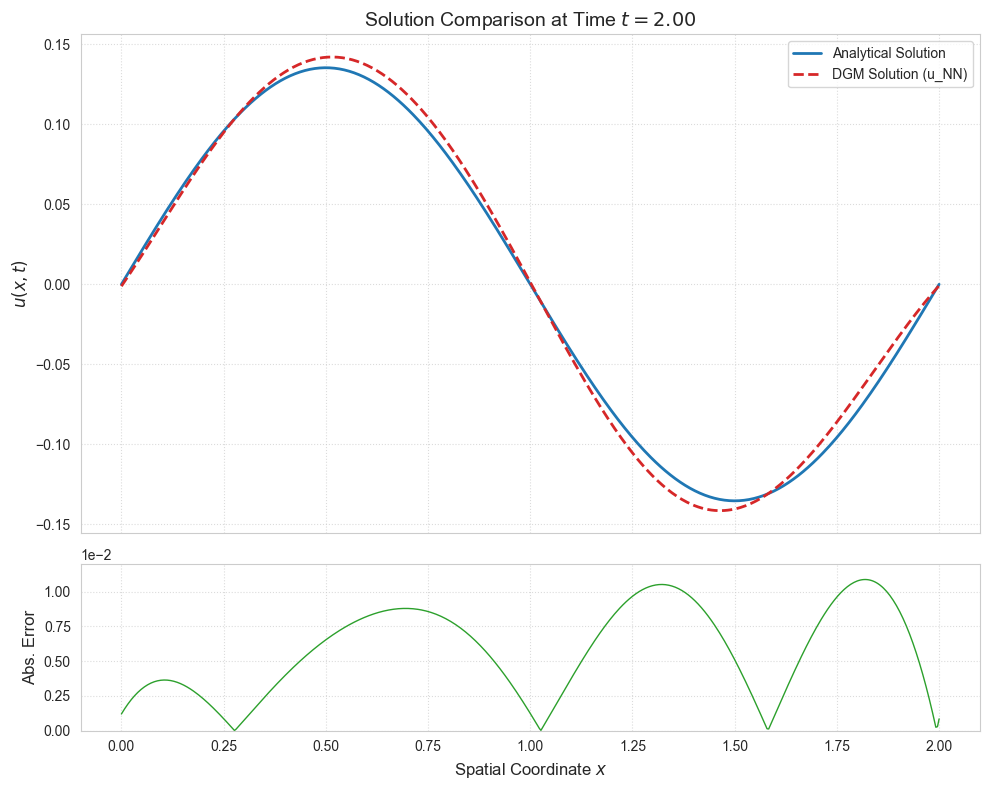

In [9]:
t_test_time = 2
visualize_solution(
    model=model,
    lx_1d=lx_1d,
    t_test=t_test_time,
    n_test_points=500
)

# Deep Galerkin Method in 2D

In [10]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01
PDE_CONSTANTS = {'alpha': ALPHA}

# Data Sizes
N_INT = 2500
N_IC = 400
N_BC =400


## Data Preparation

In [11]:

# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords, t_int = generate_domain_points(N_INT, bounds_2d, T_max)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_txy = source_term_fn_2D(t_int, x_int, y_int, ALPHA).to(device)
interior_data = (t_int, x_int, y_int,  f_txy)

# 2. Initial Condition Data (t = 0, x in [0, lx_1d])
spatial_coords_ic = generate_ic_points(N_IC, bounds_2d)
x_ic = spatial_coords_ic[:, 0:1]
y_ic = spatial_coords_ic[:, 1:2]
t_ic = torch.zeros_like(x_ic[:, 0:1]).to(device)
u_ic = initial_condition_fn_2D(x_ic,y_ic).to(device)
ic_data = (t_ic, x_ic, y_ic, u_ic)

# 3. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_boundary_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
t_bc = torch.rand_like(x_bc[:, 0:1]) * T_max # Sample time for boundary points
u_bc = boundary_condition_fn_2D(t_bc, x_bc, y_bc).to(device)
bc_data = (t_bc, x_bc,y_bc, u_bc)

## Visualizing the sampled data

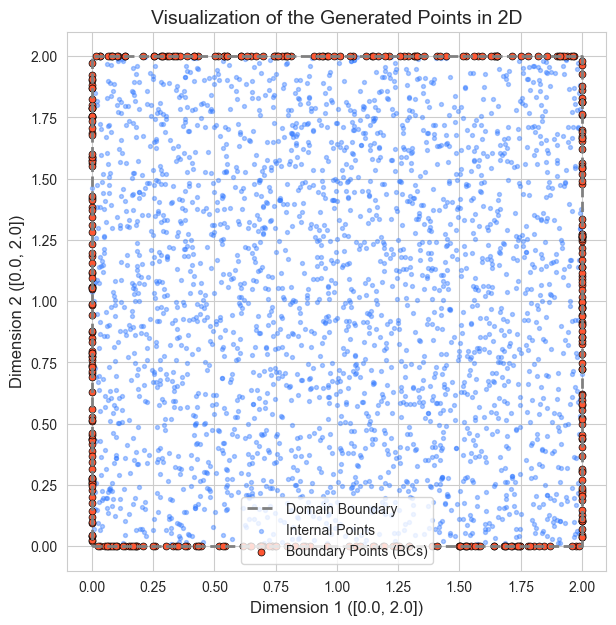

In [12]:
visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Neural Network Initialization

In [13]:
num_layers = 6
nodes_per_layer = 64
learning_rate = 0.001
epochs = 6000

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainer_2D(
    model=model,
    pde_constants=PDE_CONSTANTS,
    learning_rate=learning_rate
)

## Training

In [14]:
trainer.train(
    epochs=epochs,
    interior_data=interior_data,
    ic_data=ic_data,
    bc_data=bc_data,
    lambda_ic=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 2500, IC: 400, BC: 400 points.
Epoch 100/6000 | Total Loss: 1.5356 | L_pde: 0.0424 | L_ic: 0.0230 | L_bc: 0.0068
Epoch 200/6000 | Total Loss: 0.5953 | L_pde: 0.0314 | L_ic: 0.0087 | L_bc: 0.0026
Epoch 300/6000 | Total Loss: 0.3688 | L_pde: 0.0199 | L_ic: 0.0053 | L_bc: 0.0017
Epoch 400/6000 | Total Loss: 0.1290 | L_pde: 0.0130 | L_ic: 0.0018 | L_bc: 0.0006
Epoch 500/6000 | Total Loss: 0.1180 | L_pde: 0.0091 | L_ic: 0.0015 | L_bc: 0.0007
Epoch 600/6000 | Total Loss: 0.0361 | L_pde: 0.0050 | L_ic: 0.0005 | L_bc: 0.0002
Epoch 700/6000 | Total Loss: 0.0250 | L_pde: 0.0032 | L_ic: 0.0003 | L_bc: 0.0001
Epoch 800/6000 | Total Loss: 0.0179 | L_pde: 0.0024 | L_ic: 0.0002 | L_bc: 0.0001
Epoch 900/6000 | Total Loss: 0.0147 | L_pde: 0.0020 | L_ic: 0.0002 | L_bc: 0.0001
Epoch 1000/6000 | Total Loss: 0.0111 | L_pde: 0.0015 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1100/6000 | Total Loss: 0.0098 | L_pde: 0.0014 | L_ic: 0.0001 | L_bc: 0.0001
Epoch 1200/6000 | Total Loss:

## Visualization

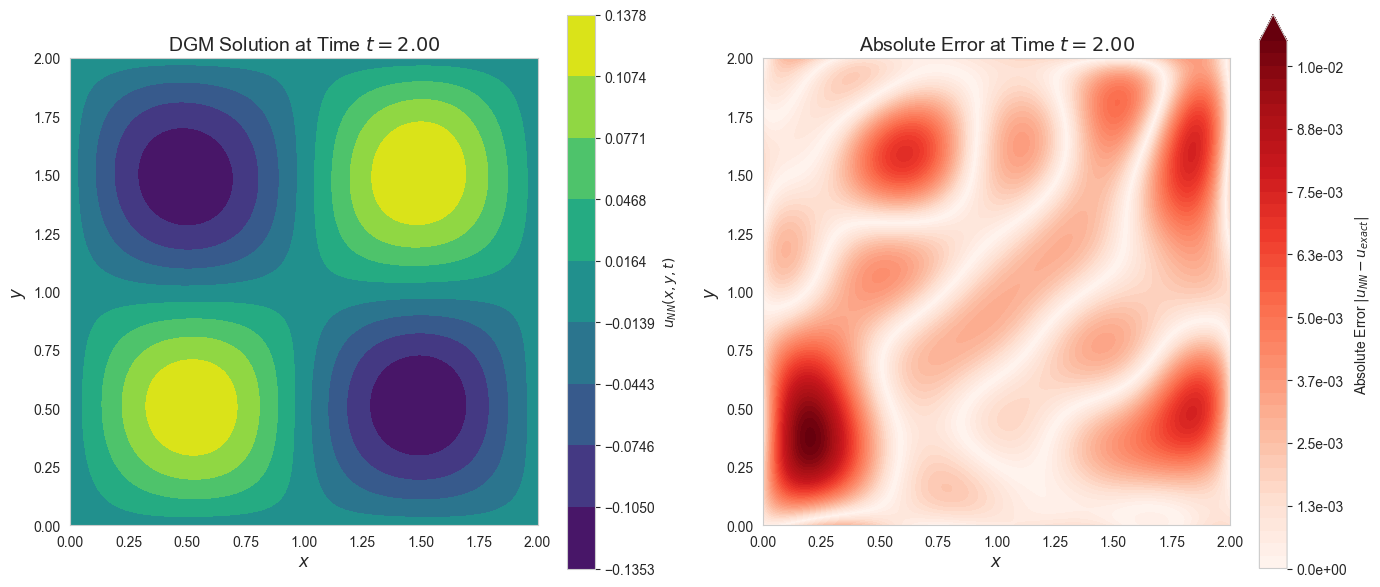

In [15]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)

/Users/abhijithsai/PycharmProjects/deep_galerkin_methods_v2/visualize.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


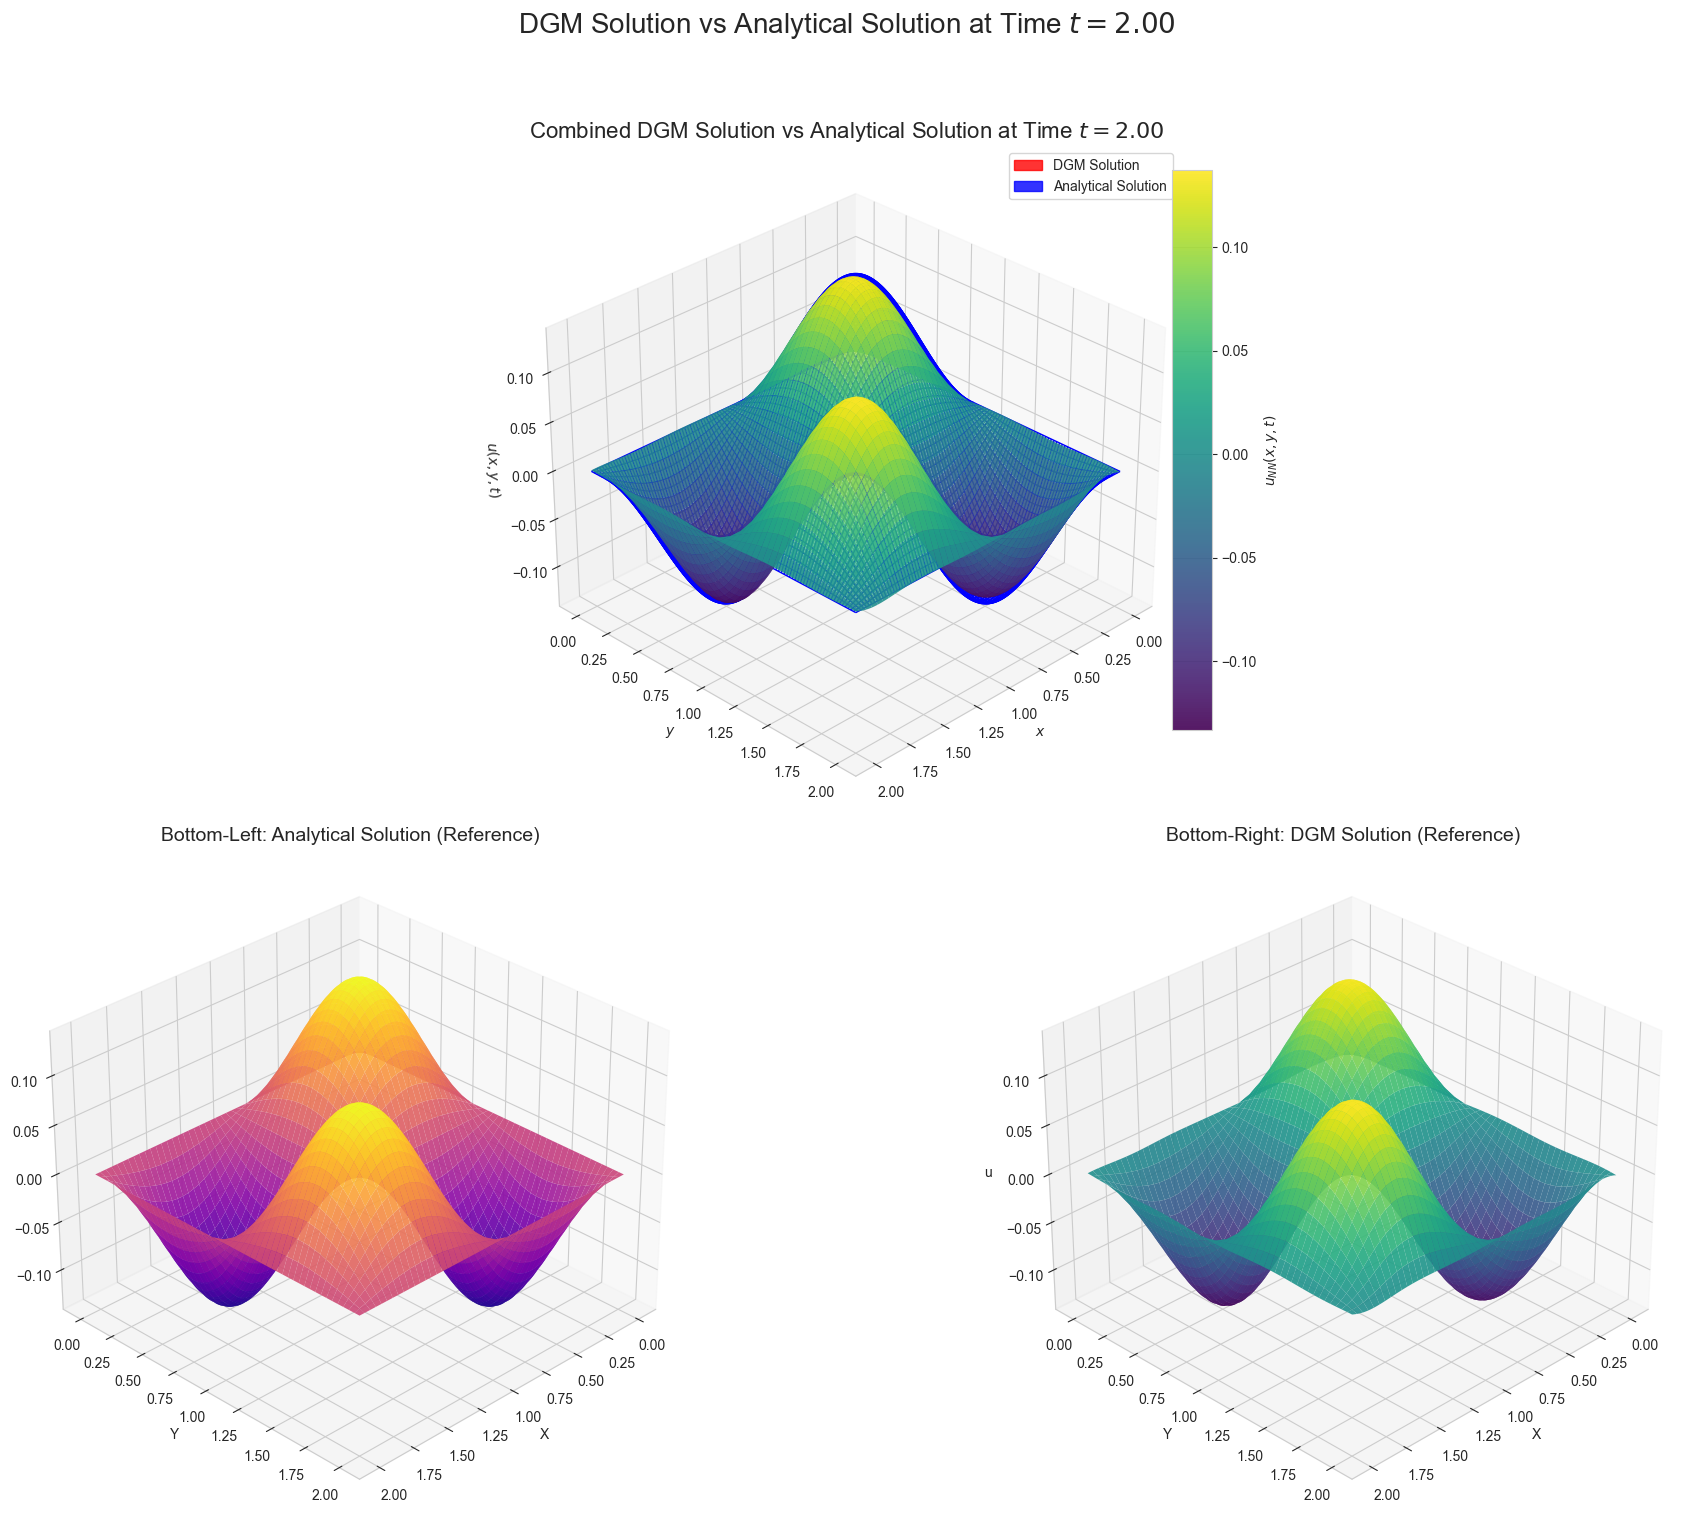

In [16]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    t_test=t_test_time,
    n_grid=500
)